# Pre-processing

### Read the datasets file which downloaded from Dr.Julian McAuley's website http://jmcauley.ucsd.edu/data/amazon/

In [1]:
import json

reviews = []
labels = []
with open('Musical_Instruments_5.json', 'r') as fr:
    lines = fr.readlines()
for line in lines:
    line = line.strip()
    tmp_line = eval(line)
    score = float(tmp_line['overall'])
    text = tmp_line['reviewText']
    reviews.append(text)
    ## discretize them into 3 sentiment categories (0:negative, 1:neutral, 2:positive)
    #label =0
#     if score>=5.0:
#         label = 2
#     elif score>=4.0:
#         label = 1
#     else:
#         label = 0
    labels.append(score)

In [2]:
print('current labels for text',set(labels))

current labels for text {1.0, 2.0, 3.0, 4.0, 5.0}


### Preprocess the field "reviewText"¶

In [3]:
## remove the symbol, digital numbers
def preprocess(reviews):
    word_list = reviews.split(' ')
    new_word_list = []
    for word in word_list:
        if word.isalpha():
            new_word_list.append(word)
    return ' '.join(new_word_list)

for i  in range(len(reviews)):
    reviews[i] = preprocess(reviews[i])

In [4]:
from nltk.corpus import stopwords
##from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re

In [5]:
def text_to_wordlist(text,is_lower=False,remove_stopwords=False,stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem/lemmate words.
    if is_lower:
        text = [w.lower() for w in text.strip().split()]#lower the words
    else:
        text = [w for w in text.strip().split()]
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]

    text = " ".join(text)
     # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    # Optionally, shorten words to their stemmer/lemmatization
    # Compare the result between stemming and lemmatization, the lemmatization find the orginal form of the word 
    # better than using stemming, eg, "despite" trans to "despit" in stemming, to "despite" in lemmatization
    # to much shorten in stemmer
    if stem_words:
        text = text.split()
        ##stemmer = SnowballStemmer('english')
        stemmer = WordNetLemmatizer()
        ##stemmed_words = [stemmer.stem(word) for word in text]
        stemmed_words = [stemmer.lemmatize(word) for word in text]
        text = " ".join(stemmed_words)

    # Return a list of words
    return (text)

In [6]:
print('orginal text:','-'*15,reviews[0])
for i  in range(len(reviews)):
    reviews[i] = text_to_wordlist(reviews[i],is_lower=True,remove_stopwords=True,stem_words=True)
print('processed text','-'*15,reviews[0])

orginal text: --------------- Not much to write about but it does exactly what supposed filters out the pop now my recordings are much more it is one of the lowest prices pop filters on amazon so might as well buy they honestly work the same despite their
processed text --------------- much write exactly supposed filter pop recording much one lowest price pop filter amazon might well buy honestly work despite


## Split the dataset in a training set and test set

In [7]:
from sklearn.cross_validation import train_test_split
from pandas import DataFrame as df
import pandas as pd
train_x, test_x, train_y, test_y = train_test_split(reviews, labels,train_size=0.9)

D:\Installation\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Training the sentiment analyser

## Model 1
### Extraction the feature, categorizing and tagging words use ngram and tfidf

#### After preprocessing, using sklearn to process the text feature. Normally using Bag of Words model to count the frequence of the word, N-gram model to observe the frequence in a particular sequence,Word2vec model represents word in vector. Using the TfidfVectorizer to convert the text to vector according to the term frequence, and using ngram_range from CountVectorizer for N-grams chocing

In [77]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
#Filter words that appear in sentences that exceed max_df/lower than min_df
#Allow max two consistent word to be combined as a new feature, because we analyse feature as word vector
#Remove the terms that appear in less than 1% of the documents
tfidf_vec = TfidfVectorizer(ngram_range=(1,2),min_df=0.01) 
def extract_tfidf_(reviews,is_train=True):
    if is_train:
        tfidf_matrix = tfidf_vec.fit_transform(reviews)
    else:
        tfidf_matrix = tfidf_vec.transform(reviews)
    return tfidf_matrix

In [78]:
train_tfidf = extract_tfidf_(train_x,True)

In [79]:
train_tfidf.shape,len(train_x)

((9234, 601), 9234)

In [80]:
test_tfidf = extract_tfidf_(test_x,False)

In [81]:
test_tfidf.shape,len(test_x)

((1027, 601), 1027)

### Extraction more text features for analysis

In [145]:
import numpy as np
import scipy.sparse
from sklearn.decomposition import PCA,NMF
#base statistics features for length
def extract_base_features(reviews,is_words=False,is_chars=False):
    if is_chars:
        _features = [len(''.join(set(str(line).replace(' ', '')))) for line in reviews]
    if is_words:
        _features = [len(str(line)) for line in reviews]
    return np.array(_features).reshape(-1,1)
#Reduce dimensional features
#Tfidf is typically a sparse matrix, which doesn’t support all the usual matrix or array operations
#Nmf is a non-negative matrix factorization that can be obtained as a positive statistics feature to dense format
#NMF can't set default number of topics, so add manually for it, there is only one file (music instrument) input
no_topics = 1
nmf=NMF(n_components=no_topics,random_state=1)
def extract_nmf_features(tf_idfs,is_train=True):
    if is_train:
        nmf.fit(tf_idfs)
    return nmf.transform(tf_idfs)

In [146]:
train_nmf = extract_nmf_features(train_tfidf,True)
test_nmf = extract_nmf_features(test_tfidf,False)

In [147]:
train_words = extract_base_features(train_x,is_words=True)
train_chars = extract_base_features(train_x,is_chars=True)
test_words = extract_base_features(test_x,is_words=True)
test_chars = extract_base_features(test_x,is_chars=True)

In [148]:
train_features = np.hstack([train_tfidf.toarray(),train_nmf,train_words,train_chars])
test_features = np.hstack([test_tfidf.toarray(),test_nmf,test_words,test_chars])

In [149]:
print(train_features.shape,test_features.shape)

(9234, 604) (1027, 604)


In [152]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % topic_idx)
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [153]:
no_top_words = 10
tfidf_feature_names = tfidf_vec.get_feature_names()
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
guitar string sound one like good great work use pedal


### Feature selection by random forest, random forest is one of the feature-based classifiers, it easy to understand and avoid over-fitting

In [157]:
names = ['fea_{%s}'%(str(i)) for i in range(train_features.shape[1])]

In [158]:
from tqdm import tqdm

In [159]:
#select features by rf and training the random forest model
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import numpy as np
#too many depth for the decision tree makes the organization chart complexity
rf = RandomForestRegressor(n_estimators=20, max_depth=4)
scores = []
for i in tqdm(range(train_features.shape[1])):
    score = cross_val_score(rf, train_features[:, i:i+1], train_y, scoring="r2",
                            cv=ShuffleSplit(len(train_features), 3, .3))
    scores.append((format(np.mean(score), '.3f'), names[i]))
print(sorted(scores, reverse=True))

100%|████████████████████████████████████████| 604/604 [00:44<00:00, 10.19it/s]


[('0.011', 'fea_{595}'), ('0.010', 'fea_{214}'), ('0.008', 'fea_{142}'), ('0.007', 'fea_{350}'), ('0.006', 'fea_{202}'), ('0.006', 'fea_{127}'), ('0.005', 'fea_{602}'), ('0.005', 'fea_{297}'), ('0.005', 'fea_{235}'), ('0.004', 'fea_{84}'), ('0.004', 'fea_{115}'), ('0.003', 'fea_{216}'), ('0.003', 'fea_{213}'), ('0.002', 'fea_{76}'), ('0.002', 'fea_{603}'), ('0.002', 'fea_{544}'), ('0.002', 'fea_{502}'), ('0.002', 'fea_{497}'), ('0.002', 'fea_{38}'), ('0.002', 'fea_{35}'), ('0.002', 'fea_{211}'), ('0.002', 'fea_{149}'), ('0.001', 'fea_{80}'), ('0.001', 'fea_{7}'), ('0.001', 'fea_{60}'), ('0.001', 'fea_{559}'), ('0.001', 'fea_{555}'), ('0.001', 'fea_{51}'), ('0.001', 'fea_{479}'), ('0.001', 'fea_{399}'), ('0.001', 'fea_{379}'), ('0.001', 'fea_{375}'), ('0.001', 'fea_{372}'), ('0.001', 'fea_{369}'), ('0.001', 'fea_{34}'), ('0.001', 'fea_{283}'), ('0.001', 'fea_{22}'), ('0.001', 'fea_{229}'), ('0.001', 'fea_{197}'), ('0.001', 'fea_{181}'), ('0.000', 'fea_{79}'), ('0.000', 'fea_{591}'), ('0

### Classify text use Naive Bayes Classifiers, because it has better result for text classify

In [160]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()   # Use defaul value to init navie bayes model
mnb.fit(train_features,train_y)    # Use training set to fit navie bayes model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Output Result

In [161]:
mnb.score(test_features, test_y)

0.6095423563777994

Handling high dimension features through tree models

could not normalize applying tree models

In [162]:
from sklearn.ensemble import RandomForestClassifier

In [163]:
feature_selected = [int(line[1][5:-1]) for line in sorted(scores, reverse=True)]

In [164]:
clf=RandomForestClassifier(n_estimators=100,max_depth=None,random_state=1123,
          n_jobs=13,min_weight_fraction_leaf=0,criterion='gini',
          min_samples_leaf=5)

Set early stop to exit feature selection if it has not grown 

In [165]:
best_score = 0
num_used = 0
its = 0
early_stops = 10
for num_feas in range(10,len(feature_selected),10):
    print('number feauture used',num_feas)
    clf.fit(train_features[:,feature_selected[:num_feas]] ,train_y)
    cur_score = clf.score(test_features[:,feature_selected[:num_feas]],test_y)
    if cur_score>best_score:
        num_used = num_feas
        best_score = cur_score
        print('best score:',best_score)
        print('feature used:',num_used)
        its=0
    else:
        its+=1
    if its>=early_stops:
        print('exit!')
        break

number feauture used 10
best score: 0.6874391431353457
feature used: 10
number feauture used 20
best score: 0.6932814021421616
feature used: 20
number feauture used 30
number feauture used 40
number feauture used 50
number feauture used 60
number feauture used 70
number feauture used 80
number feauture used 90
number feauture used 100
number feauture used 110
number feauture used 120
exit!


## Model 2: Use features derived from a sentiment lexicon

### Read sentiment lexicons which download from public internet

In [166]:
sentiment_dict = {}
with open('SentiWordNet.txt', 'r') as fr:
    lines = fr.readlines()
for line in lines:
    line = line.strip()
    if line[0]!='#' and line!='':
        word_info = line.split('#')[0].split('\t')
        tmp = {}
        tmp['pos'] = word_info[2]
        tmp['neg'] = word_info[3]
        sentiment_dict[word_info[-1]] = tmp

In [167]:
sentiment_dict

{'able': {'pos': '0.125', 'neg': '0'},
 'unable': {'pos': '0.125', 'neg': '0.25'},
 'dorsal': {'pos': '0', 'neg': '0'},
 'ventral': {'pos': '0', 'neg': '0'},
 'acroscopic': {'pos': '0', 'neg': '0'},
 'basiscopic': {'pos': '0', 'neg': '0'},
 'abducting': {'pos': '0', 'neg': '0'},
 'adductive': {'pos': '0', 'neg': '0'},
 'nascent': {'pos': '0', 'neg': '0'},
 'emerging': {'pos': '0', 'neg': '0'},
 'dissilient': {'pos': '0.25', 'neg': '0'},
 'parturient': {'pos': '0', 'neg': '0'},
 'dying': {'pos': '0', 'neg': '0.625'},
 'moribund': {'pos': '0', 'neg': '0'},
 'last': {'pos': '0', 'neg': '0'},
 'abridged': {'pos': '0', 'neg': '0'},
 'shortened': {'pos': '0', 'neg': '0'},
 'half-length': {'pos': '0.375', 'neg': '0'},
 'potted': {'pos': '0', 'neg': '0'},
 'unabridged': {'pos': '0', 'neg': '0'},
 'uncut': {'pos': '0.375', 'neg': '0.25'},
 'absolute': {'pos': '0', 'neg': '0.25'},
 'direct': {'pos': '0.125', 'neg': '0'},
 'unquestioning': {'pos': '0.25', 'neg': '0.625'},
 'infinite': {'pos': '0.

### Analysis the range of sentiment lexicon

In [197]:
pos_max = 0
pos_min = 0
neg_max = 0
neg_min = 0
for sen in sentiment_dict:
    pos = float(sentiment_dict[sen]['pos'])
    neg = float(sentiment_dict[sen]['neg'])
    if pos>pos_max:
        pos_max = pos
    elif pos<pos_min:
        pos_min = pos
    if neg>neg_max:
        neg_max = neg
    elif neg<neg_min:
        neg_min = neg

In [198]:
print(pos_max)
print(pos_min)
print(neg_max)
print(neg_min)

1.0
0
1.0
0


In [199]:
## Traversing the original dataset, and compare with the sentiment dictionary. If it is the positive sentiment word,
## then increase the value of the word, reversely if it is the negative sentiment word, then decrease the value.
## Finally calculate the sentiment value and reflect them into the 5-point scale scores
def compute(review):
    word_list = review.split(' ')
    value = 0
    for word in word_list:    ## Adjust sentiment value and calculation method
        num = 0
        if word in sentiment_dict:
            if float(sentiment_dict[word]['pos'])>=float(sentiment_dict[word]['neg']):
                value += float(sentiment_dict[word]['pos'])
                num += 1
            else:
                value -= float(sentiment_dict[word]['neg'])
                num += 1
    if num>0:
        value /= num     
    return value
    #value*=5
#     print(value)
#     if value>=1:      ## Adjust the threshold for sentiment classification
#         return 2
#     elif value>=-3:
#         return 1
#     else:
#         return 0

In [200]:
train_lexicons_score = [compute(train_x[i]) for i in range(len(train_x))]

In [201]:
test_lexicons_score = [compute(test_x[i]) for i in range(len(test_x))]

In [202]:
import matplotlib.pyplot as plt

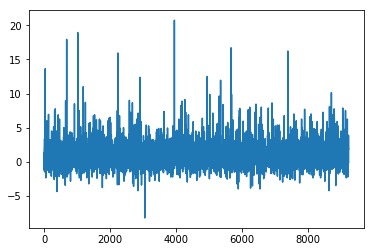

In [203]:
fig  = plt.figure()

ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(len(train_lexicons_score)),train_lexicons_score)

plt.show()

concat lexion features

In [204]:
train_final_features = np.hstack([train_features[:,feature_selected[:20]],np.array(train_lexicons_score).reshape(-1,1) ])

In [205]:
test_final_features = np.hstack([test_features[:,feature_selected[:20]],np.array(test_lexicons_score).reshape(-1,1) ])

concat all_features

In [206]:
# acc_num = 0
# total = len(train_y)
# for i in range(len(train_y)):
#     if pred_labels[i] ==train_y[i]:
#         acc_num+=1
# print('At sentiment lexicon model，the accurate of training set：', acc_num/total)

In [207]:
clf=RandomForestClassifier(n_estimators=10,max_depth=None,random_state=1,
          n_jobs=13,min_weight_fraction_leaf=0,criterion='gini',
          min_samples_leaf=5)

Tuning Super parameter

In [208]:
# num = 0
# acc_num = 0
# total = len(test_x)
# for review in test_x:
#     if compute(review)==test_y[num]:
#         acc_num+=1
#     num += 1
# print(total)
# print(acc_num)
# print('At sentiment lexicon model，the accurate of test set：', acc_num/total)

In [209]:
_n_estimators = [10,20,50,100,200]
_max_depth = [5,10,15,None]
_min_samples_leaf = [1,2,5,10]

In [210]:
_best_score = 0
for _n in _n_estimators:
    for _s in _max_depth:
        for _t in _min_samples_leaf:
            clf=RandomForestClassifier(n_estimators=_n,max_depth=_s,random_state=1,
              n_jobs=13,min_weight_fraction_leaf=0,criterion='gini',
              min_samples_leaf=_t)
            clf.fit(train_features[:,feature_selected[:20]] ,train_y)
            cur_score = clf.score(test_features[:,feature_selected[:20]],test_y)
            if cur_score>_best_score:
                _best_score = cur_score
                print('The score %s best parameters:'%(_best_score),_n,_s,_t)

The score 0.6942551119766309 best parameters: 10 5 1
The score 0.6962025316455697 best parameters: 10 5 2
The score 0.7020447906523856 best parameters: 20 15 1


In [211]:
clf.fit(train_features[:,feature_selected[:20]] ,train_y)
print(clf.score(test_features[:,feature_selected[:20]],test_y))

0.691333982473223


In [214]:
#print('At sentiment lexicon model，the accurate of training set：', clf.score(train_final_features,train_y))
#print('At sentiment lexicon model，the accurate of test set：', clf.score(test_final_features,test_y))

In [212]:
clf=RandomForestClassifier(n_estimators=10,max_depth=None,random_state=1,
          n_jobs=13,min_weight_fraction_leaf=0,criterion='gini',
          min_samples_leaf=5)
clf.fit(train_features[:,feature_selected[:20]] ,train_y)
print(clf.score(test_features[:,feature_selected[:20]],test_y))

0.6864654333008764


In [215]:
print('The accurate of using lexicon：')
clf.fit(train_final_features ,train_y)
print(clf.score(test_final_features,test_y))

The accurate of using lexicon：
0.691333982473223


# Compare and Discussion

#### 分类模型比情感词典的方式更有效，情感字典作为额外特征对最终效果有下降影响，需要考虑进一步算法提升情感字典